# Bet Sizing Tutorial

## From ML Predictions to Position Sizes

This notebook demonstrates the bet sizing techniques from **AFML Chapter 10**.

**The Problem**: ML models output probabilities (e.g., 0.75 probability of price going up), but we need actual position sizes (e.g., invest 50% of capital).

**The Solution**: Transform probabilities into bet sizes using statistical methods that account for prediction confidence.

### Topics Covered

1. **Probability to Bet Size** - Converting classifier probabilities to positions
2. **Averaging Active Bets** - Reducing turnover with overlapping signals
3. **Size Discretization** - Preventing overtrading from small signal changes
4. **Dynamic Position Sizing** - Market maker approach with limit prices

### Reference
López de Prado, M. (2018). *Advances in Financial Machine Learning*. Chapter 10: Bet Sizing.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# AFML bet sizing imports
from afml.bet_sizing import (
    # Probability to bet size
    compute_bet_size_from_probability,
    get_signal_from_probabilities,
    probability_to_bet_size_binary,
    get_bet_size_sigmoid,
    # Averaging
    compute_average_active_signals,
    compute_signal_with_decay,
    resample_signals,
    compute_turnover,
    # Discretization
    discretize_signal,
    get_discrete_levels,
    should_trade,
    adaptive_discretization,
    # Dynamic sizing
    bet_size_sigmoid,
    bet_size_power,
    compute_target_position,
    inverse_price_sigmoid,
    get_position_schedule,
    get_limit_price_schedule,
    dynamic_position_update,
)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("Imports successful!")

Imports successful!


---

## 1. Probability to Bet Size

### The Core Problem

An ML classifier outputs a probability like `P(up) = 0.75`. How much should we bet?

**Naive approach**: Bet proportional to probability → `bet = 0.75`

**Problem**: This doesn't account for statistical significance. A probability of 0.51 is barely better than random chance, yet would suggest a 51% position!

### The Statistical Approach

We treat the probability as a hypothesis test:
- **Null hypothesis**: The prediction is no better than random chance (p = 0.5 for binary)
- **Test statistic**: How many standard deviations is our probability from chance?

The z-score formula:

$$z = \frac{p - p_0}{\sqrt{p(1-p)}}$$

Where:
- $p$ = predicted probability
- $p_0$ = null probability (0.5 for binary, 1/|X| for multi-class)

The bet size:

$$m = 2 \cdot \Phi(z) - 1$$

Where $\Phi$ is the standard normal CDF.

/Users/oualid/Documents/Projects/omroot_repos/AFML/afml/bet_sizing/probability.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (probability - null_probability) / np.sqrt(


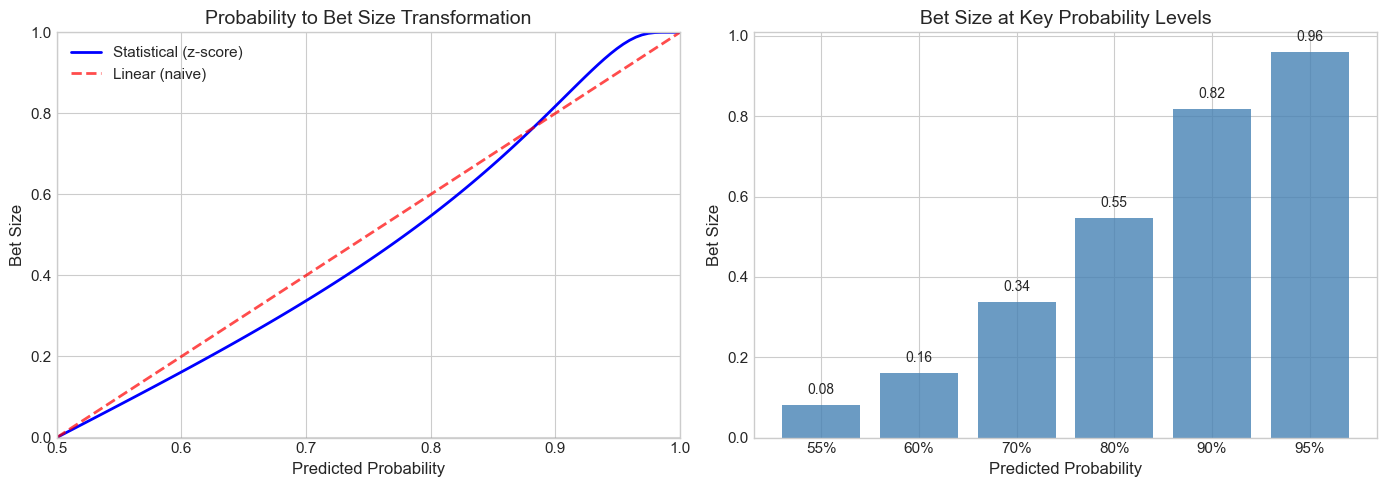


Key insight: The statistical approach is more conservative at low probabilities.
A 55% probability only warrants a ~15% position, not 55%!


In [2]:
# Visualize the probability to bet size transformation
probabilities = np.linspace(0.5, 1.0, 100)
bet_sizes = [compute_bet_size_from_probability(p, num_classes=2) for p in probabilities]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Transformation curve
ax1 = axes[0]
ax1.plot(probabilities, bet_sizes, 'b-', linewidth=2, label='Statistical (z-score)')
ax1.plot(probabilities, 2*probabilities - 1, 'r--', linewidth=2, alpha=0.7, label='Linear (naive)')
ax1.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
ax1.axvline(x=0.5, color='gray', linestyle='-', alpha=0.3)
ax1.set_xlabel('Predicted Probability', fontsize=12)
ax1.set_ylabel('Bet Size', fontsize=12)
ax1.set_title('Probability to Bet Size Transformation', fontsize=14)
ax1.legend()
ax1.set_xlim(0.5, 1.0)
ax1.set_ylim(0, 1.0)

# Right plot: Key probability points
ax2 = axes[1]
key_probs = [0.55, 0.6, 0.7, 0.8, 0.9, 0.95]
key_bets = [compute_bet_size_from_probability(p) for p in key_probs]

bars = ax2.bar(range(len(key_probs)), key_bets, color='steelblue', alpha=0.8)
ax2.set_xticks(range(len(key_probs)))
ax2.set_xticklabels([f'{p:.0%}' for p in key_probs])
ax2.set_xlabel('Predicted Probability', fontsize=12)
ax2.set_ylabel('Bet Size', fontsize=12)
ax2.set_title('Bet Size at Key Probability Levels', fontsize=14)

# Add value labels
for bar, bet in zip(bars, key_bets):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{bet:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nKey insight: The statistical approach is more conservative at low probabilities.")
print("A 55% probability only warrants a ~15% position, not 55%!")

### Understanding the Transformation

The key insight is that **statistical significance matters**:

| Probability | Naive Bet | Statistical Bet | Interpretation |
|-------------|-----------|-----------------|----------------|
| 55% | 55% | ~15% | Barely significant → small bet |
| 70% | 70% | ~34% | Moderate signal → moderate bet |
| 90% | 90% | ~82% | Strong signal → large bet |
| 95% | 95% | ~90% | Very strong → near full position |

In [3]:
# Demonstrate with specific examples
print("Probability to Bet Size Examples:")
print("=" * 50)

for prob in [0.51, 0.55, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]:
    bet = compute_bet_size_from_probability(prob, num_classes=2)
    naive = 2 * prob - 1
    print(f"P = {prob:.2f} → Bet = {bet:.4f} (naive: {naive:.4f})")

Probability to Bet Size Examples:
P = 0.51 → Bet = 0.0160 (naive: 0.0200)
P = 0.55 → Bet = 0.0801 (naive: 0.1000)
P = 0.60 → Bet = 0.1617 (naive: 0.2000)
P = 0.70 → Bet = 0.3375 (naive: 0.4000)
P = 0.80 → Bet = 0.5467 (naive: 0.6000)
P = 0.90 → Bet = 0.8176 (naive: 0.8000)
P = 0.95 → Bet = 0.9611 (naive: 0.9000)
P = 0.99 → Bet = 1.0000 (naive: 0.9800)


### Multi-Class Classification

For multi-class problems, the null probability changes from 0.5 to 1/|X| where |X| is the number of classes.

For example, with 3 classes:
- Random chance = 33.3%
- A probability of 50% is now more significant than in the binary case

/Users/oualid/Documents/Projects/omroot_repos/AFML/afml/bet_sizing/probability.py:90: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (probability - null_probability) / np.sqrt(


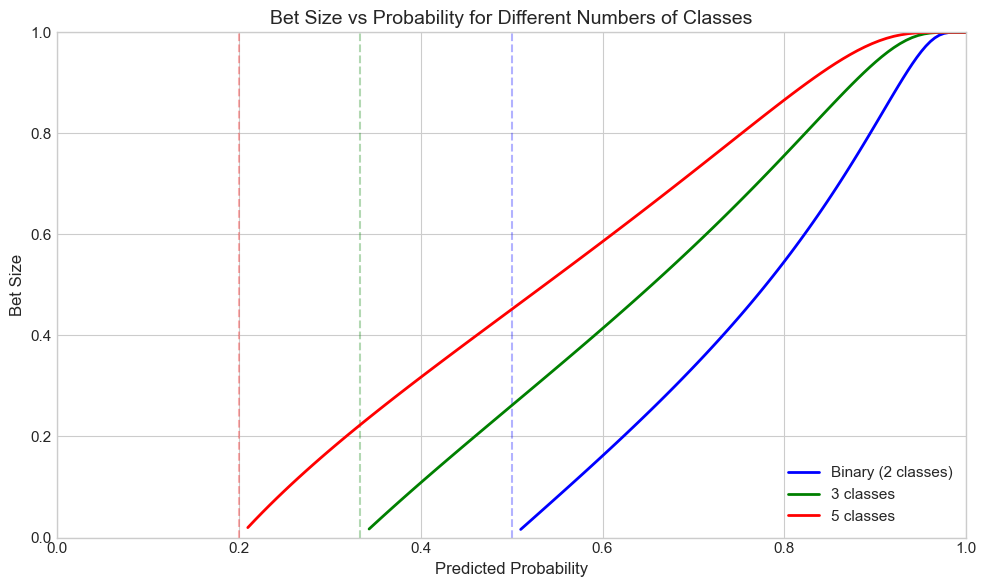


Note: Vertical dashed lines show the null probability (random chance) for each case.


In [4]:
# Compare binary vs multi-class
fig, ax = plt.subplots(figsize=(10, 6))

for num_classes, color, label in [(2, 'blue', 'Binary (2 classes)'),
                                   (3, 'green', '3 classes'),
                                   (5, 'red', '5 classes')]:
    null_prob = 1.0 / num_classes
    probs = np.linspace(null_prob + 0.01, 1.0, 100)
    bets = [compute_bet_size_from_probability(p, num_classes=num_classes) for p in probs]
    ax.plot(probs, bets, color=color, linewidth=2, label=label)
    ax.axvline(x=null_prob, color=color, linestyle='--', alpha=0.3)

ax.set_xlabel('Predicted Probability', fontsize=12)
ax.set_ylabel('Bet Size', fontsize=12)
ax.set_title('Bet Size vs Probability for Different Numbers of Classes', fontsize=14)
ax.legend()
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

print("\nNote: Vertical dashed lines show the null probability (random chance) for each case.")

### Applying Side (Long/Short)

The bet size formula gives magnitude. We apply the predicted side to get the signed position:

- **Side = +1 (long)**: Position = +bet_size
- **Side = -1 (short)**: Position = -bet_size

Converting Probabilities to Trading Signals:
 Probability  Prediction  Signal  Abs_Signal
      0.6998           1  0.3371      0.3371
      0.9303          -1 -0.9089      0.9089
      0.8428           1  0.6537      0.6537
      0.7895           1  0.5223      0.5223
      0.6124           1  0.1825      0.1825
      0.6124           1  0.1825      0.1825
      0.5732           1  0.1177      0.1177
      0.8965           1  0.8069      0.8069
      0.7904           1  0.5246      0.5246
      0.8332           1  0.6286      0.6286


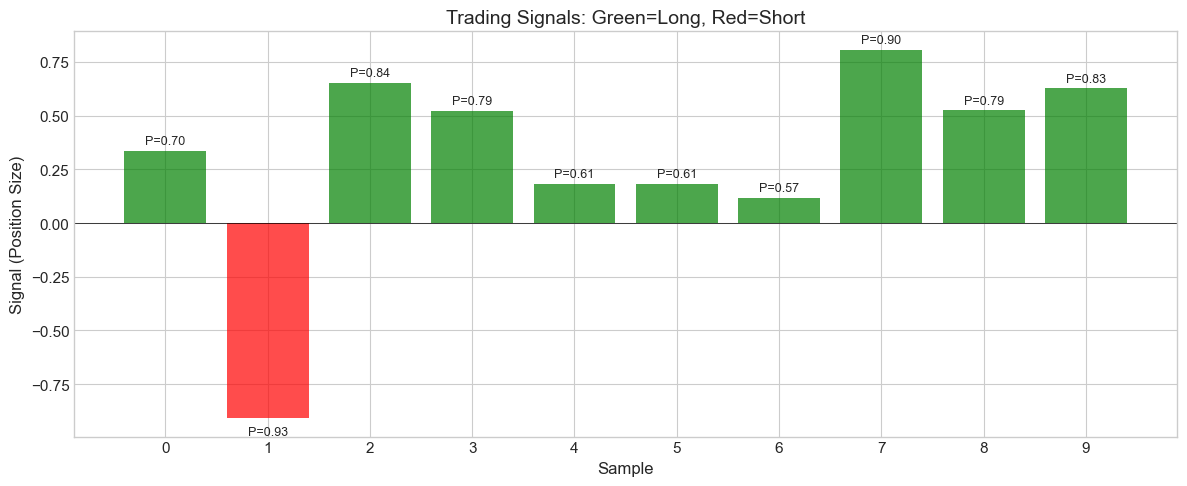

In [5]:
# Batch conversion of probabilities to signals
np.random.seed(42)

# Simulate classifier output
n_samples = 10
probabilities = np.random.uniform(0.55, 0.95, n_samples)
predictions = np.random.choice([-1, 1], n_samples)

# Convert to signals
signals = get_signal_from_probabilities(probabilities, predictions, num_classes=2)

# Display results
results = pd.DataFrame({
    'Probability': probabilities,
    'Prediction': predictions,
    'Signal': signals.values
})
results['Abs_Signal'] = np.abs(results['Signal'])

print("Converting Probabilities to Trading Signals:")
print("=" * 60)
print(results.round(4).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(12, 5))
colors = ['green' if s > 0 else 'red' for s in signals]
bars = ax.bar(range(len(signals)), signals, color=colors, alpha=0.7)
ax.axhline(y=0, color='black', linewidth=0.5)
ax.set_xlabel('Sample', fontsize=12)
ax.set_ylabel('Signal (Position Size)', fontsize=12)
ax.set_title('Trading Signals: Green=Long, Red=Short', fontsize=14)
ax.set_xticks(range(len(signals)))

# Add probability labels
for i, (bar, prob) in enumerate(zip(bars, probabilities)):
    y_pos = bar.get_height() + 0.03 if bar.get_height() > 0 else bar.get_height() - 0.08
    ax.text(i, y_pos, f'P={prob:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

---

## 2. Averaging Active Bets

### The Problem with Overlapping Signals

In real trading:
- Multiple predictions may be active simultaneously
- Each prediction has a **holding period** (from entry to exit)
- These holding periods often overlap

**Question**: If we have 3 active signals: +0.5, -0.3, +0.8, what should our position be?

**Answer**: Average them → (+0.5 - 0.3 + 0.8) / 3 = 0.33

### Benefits of Averaging

1. **Reduces turnover**: Position changes gradually as signals expire
2. **Diversification**: Position reflects multiple predictions
3. **Smoother P&L**: Less whipsaw from individual signal changes

In [6]:
# Create sample events with overlapping holding periods
dates = pd.date_range('2023-01-01', periods=10, freq='D')

# Events: each signal has a start date (index) and end date (t1)
events = pd.DataFrame({
    't1': [dates[3], dates[5], dates[6], dates[8], dates[9]]
}, index=[dates[0], dates[1], dates[2], dates[4], dates[6]])

# Signals for each event
signals = pd.Series([0.6, -0.4, 0.8, 0.5, -0.3], index=events.index)

print("Events (holding periods):")
print("=" * 40)
event_display = pd.DataFrame({
    'Start': events.index,
    'End': events['t1'],
    'Signal': signals.values
})
print(event_display.to_string(index=False))

# Compute average active signals
avg_signals = compute_average_active_signals(signals, events)

print("\nAverage Active Signals:")
print("=" * 40)
print(avg_signals.round(4))

Events (holding periods):
     Start        End  Signal
2023-01-01 2023-01-04     0.6
2023-01-02 2023-01-06    -0.4
2023-01-03 2023-01-07     0.8
2023-01-05 2023-01-09     0.5
2023-01-07 2023-01-10    -0.3

Average Active Signals:
2023-01-01    0.6000
2023-01-02    0.1000
2023-01-03    0.3333
2023-01-04    0.2000
2023-01-05    0.3000
2023-01-06    0.6500
2023-01-07    0.1000
2023-01-09   -0.3000
2023-01-10    0.0000
dtype: float64


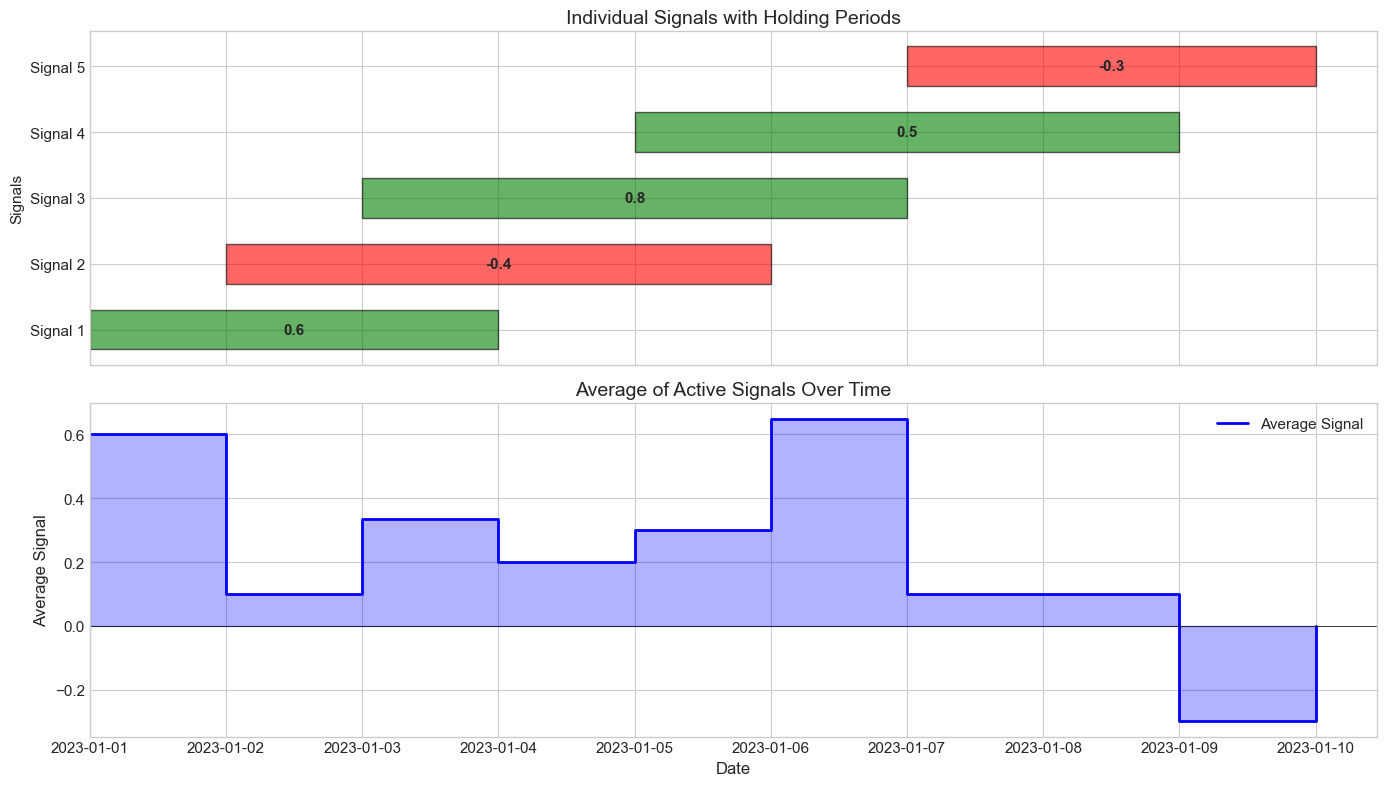


Notice how the average signal changes gradually as signals start and expire.


In [7]:
# Visualize overlapping signals and their average
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Top plot: Individual signals as horizontal bars
ax1 = axes[0]
colors = ['green' if s > 0 else 'red' for s in signals]

for i, (start, row) in enumerate(events.iterrows()):
    end = row['t1']
    signal = signals[start]
    color = 'green' if signal > 0 else 'red'
    ax1.barh(i, (end - start).days, left=start, height=0.6, 
             color=color, alpha=0.6, edgecolor='black')
    ax1.text(start + (end - start)/2, i, f'{signal:.1f}', 
             ha='center', va='center', fontweight='bold')

ax1.set_yticks(range(len(events)))
ax1.set_yticklabels([f'Signal {i+1}' for i in range(len(events))])
ax1.set_title('Individual Signals with Holding Periods', fontsize=14)
ax1.set_ylabel('Signals')

# Bottom plot: Average signal over time
ax2 = axes[1]
ax2.step(avg_signals.index, avg_signals.values, where='post', 
         linewidth=2, color='blue', label='Average Signal')
ax2.fill_between(avg_signals.index, 0, avg_signals.values, 
                 step='post', alpha=0.3, color='blue')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Average Signal', fontsize=12)
ax2.set_title('Average of Active Signals Over Time', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

print("\nNotice how the average signal changes gradually as signals start and expire.")

### Time-Decay Weighted Averaging

We can give more weight to recent signals using exponential decay:

$$w_i = e^{-\lambda \cdot \text{fraction\_elapsed}}$$

Where `fraction_elapsed` is how much of the holding period has passed.

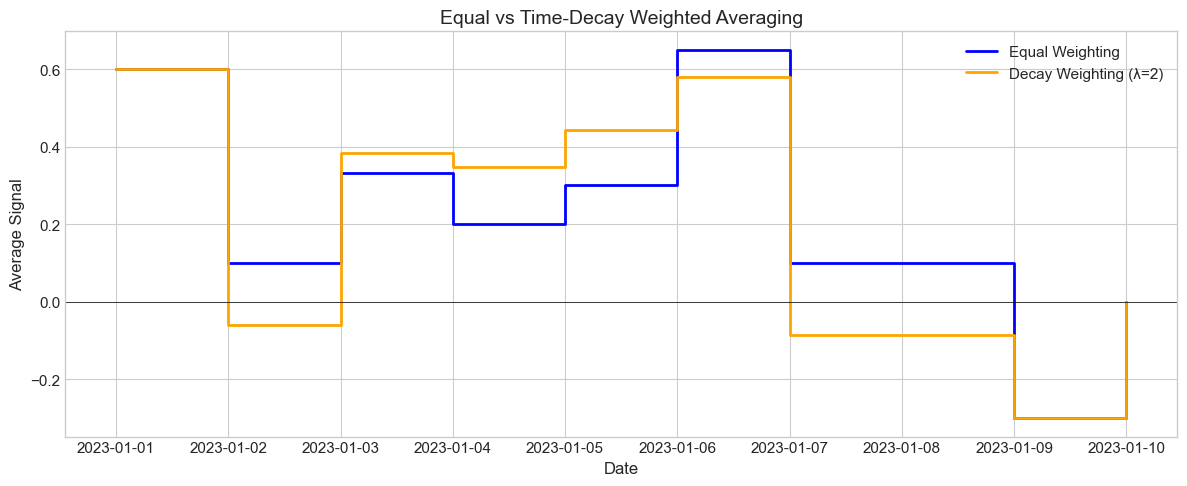

Time-decay gives more weight to newer signals within each holding period.


In [8]:
# Compare equal weighting vs decay weighting
avg_equal = compute_average_active_signals(signals, events)
avg_decay = compute_signal_with_decay(signals, events, decay_factor=2.0)

fig, ax = plt.subplots(figsize=(12, 5))

ax.step(avg_equal.index, avg_equal.values, where='post', 
        linewidth=2, color='blue', label='Equal Weighting')
ax.step(avg_decay.index, avg_decay.values, where='post', 
        linewidth=2, color='orange', label='Decay Weighting (λ=2)')
ax.axhline(y=0, color='black', linewidth=0.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Average Signal', fontsize=12)
ax.set_title('Equal vs Time-Decay Weighted Averaging', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

print("Time-decay gives more weight to newer signals within each holding period.")

### Turnover Analysis

Averaging reduces turnover (position changes), which reduces transaction costs.

Turnover Statistics:
  Total turnover: 2.5667
  Average turnover per change: 0.3208
  Max single change: 0.5500


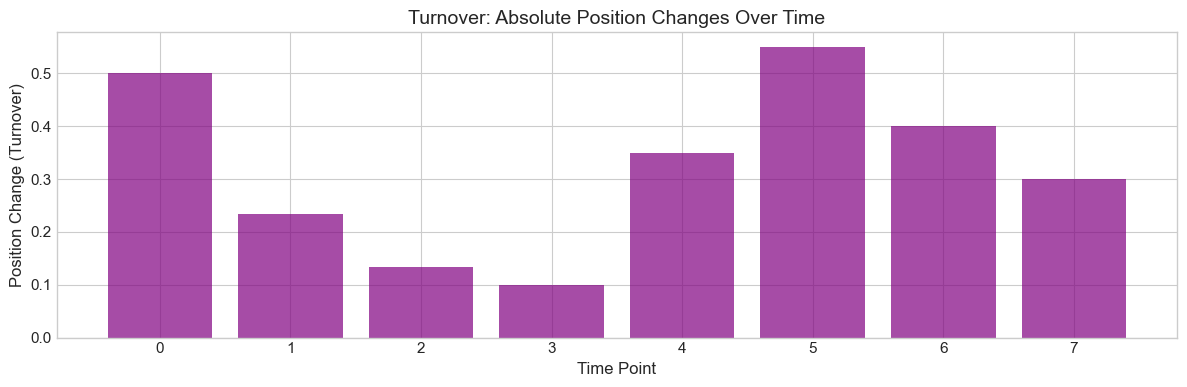

In [9]:
# Compute and visualize turnover
turnover = compute_turnover(signals, events)

print(f"Turnover Statistics:")
print(f"  Total turnover: {turnover.sum():.4f}")
print(f"  Average turnover per change: {turnover.mean():.4f}")
print(f"  Max single change: {turnover.max():.4f}")

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(range(len(turnover)), turnover.values, color='purple', alpha=0.7)
ax.set_xlabel('Time Point', fontsize=12)
ax.set_ylabel('Position Change (Turnover)', fontsize=12)
ax.set_title('Turnover: Absolute Position Changes Over Time', fontsize=14)

plt.tight_layout()
plt.show()

---

## 3. Size Discretization

### Why Discretize?

Without discretization:
- Signal changes from 0.371 to 0.378 → Trade!
- Signal changes from 0.378 to 0.382 → Trade!
- Too many small trades → High transaction costs

With discretization (step = 0.1):
- 0.371 → 0.4, 0.378 → 0.4, 0.382 → 0.4 → No trade needed!

### The Formula

$$m^* = \text{round}(m / d) \times d$$

Where:
- $m$ = continuous signal
- $d$ = step size
- $m^*$ = discretized signal

In [10]:
# Demonstrate discretization
continuous_signals = np.array([0.12, 0.28, 0.37, 0.55, 0.71, 0.87])

print("Discretization Examples:")
print("=" * 60)

for step_size in [0.1, 0.2, 0.25]:
    discrete = discretize_signal(continuous_signals, step_size)
    print(f"\nStep size = {step_size}:")
    for cont, disc in zip(continuous_signals, discrete):
        print(f"  {cont:.2f} → {disc:.2f}")

Discretization Examples:

Step size = 0.1:
  0.12 → 0.10
  0.28 → 0.30
  0.37 → 0.40
  0.55 → 0.60
  0.71 → 0.70
  0.87 → 0.90

Step size = 0.2:
  0.12 → 0.20
  0.28 → 0.20
  0.37 → 0.40
  0.55 → 0.60
  0.71 → 0.80
  0.87 → 0.80

Step size = 0.25:
  0.12 → 0.00
  0.28 → 0.25
  0.37 → 0.25
  0.55 → 0.50
  0.71 → 0.75
  0.87 → 0.75


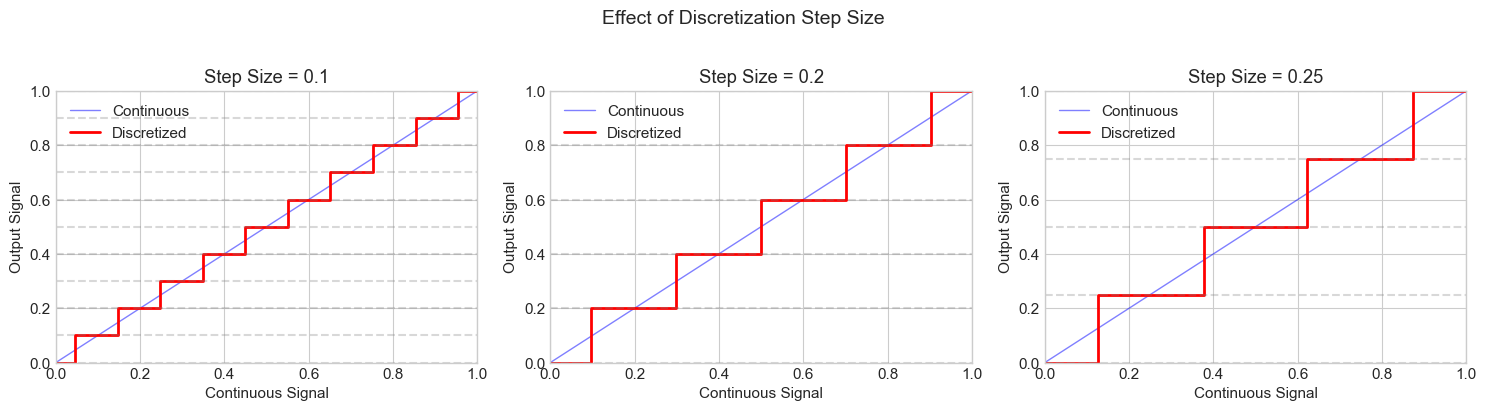

In [11]:
# Visualize discretization effect
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

continuous = np.linspace(0, 1, 100)

for ax, step_size in zip(axes, [0.1, 0.2, 0.25]):
    discrete = discretize_signal(continuous, step_size)
    
    ax.plot(continuous, continuous, 'b-', linewidth=1, alpha=0.5, label='Continuous')
    ax.step(continuous, discrete, 'r-', linewidth=2, where='mid', label='Discretized')
    
    # Show discrete levels
    levels = get_discrete_levels(step_size)
    levels = levels[levels >= 0]  # Only positive
    for level in levels:
        ax.axhline(y=level, color='gray', linestyle='--', alpha=0.3)
    
    ax.set_xlabel('Continuous Signal')
    ax.set_ylabel('Output Signal')
    ax.set_title(f'Step Size = {step_size}')
    ax.legend(loc='upper left')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

plt.suptitle('Effect of Discretization Step Size', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Trading Decision with Discretization

The `should_trade` function determines if a position change is needed.

In [12]:
# Trading decision examples
print("Trading Decisions with Discretization:")
print("=" * 60)

scenarios = [
    (0.35, 0.42),  # Both round to 0.4
    (0.35, 0.55),  # 0.4 -> 0.6
    (0.80, 0.85),  # Both round to 0.8
    (0.80, 0.95),  # 0.8 -> 1.0
]

step_size = 0.1

for current, target in scenarios:
    trade = should_trade(current, target, step_size)
    current_disc = discretize_signal(current, step_size)
    target_disc = discretize_signal(target, step_size)
    
    decision = "TRADE" if trade else "NO TRADE"
    print(f"Current: {current:.2f} ({current_disc:.1f}) → "
          f"Target: {target:.2f} ({target_disc:.1f}) → {decision}")

Trading Decisions with Discretization:
Current: 0.35 (0.3) → Target: 0.42 (0.4) → TRADE
Current: 0.35 (0.3) → Target: 0.55 (0.6) → TRADE
Current: 0.80 (0.8) → Target: 0.85 (0.8) → NO TRADE
Current: 0.80 (0.8) → Target: 0.95 (0.9) → TRADE


### Adaptive Discretization

We can use finer discretization for high-confidence signals and coarser for low-confidence:

- **High confidence** → Small step size → More precise positioning
- **Low confidence** → Large step size → Avoid overtrading on uncertain signals

In [13]:
# Demonstrate adaptive discretization
signals = np.array([0.37, 0.37, 0.37, 0.37])
confidences = np.array([0.2, 0.5, 0.8, 1.0])

print("Adaptive Discretization:")
print("=" * 50)
print("Signal = 0.37 with varying confidence:\n")

for signal, conf in zip(signals, confidences):
    discrete = adaptive_discretization(signal, conf, min_step=0.05, max_step=0.25)
    step = 0.25 - conf * (0.25 - 0.05)  # Compute effective step
    print(f"Confidence: {conf:.1f} → Step: {step:.2f} → Discrete: {discrete:.2f}")

Adaptive Discretization:
Signal = 0.37 with varying confidence:

Confidence: 0.2 → Step: 0.21 → Discrete: 0.42
Confidence: 0.5 → Step: 0.15 → Discrete: 0.30
Confidence: 0.8 → Step: 0.09 → Discrete: 0.36
Confidence: 1.0 → Step: 0.05 → Discrete: 0.35


---

## 4. Dynamic Position Sizing

### The Market Maker Perspective

A market maker has:
- A **price forecast** (fair value estimate)
- **Current market price**
- **Divergence** = forecast - price

The position should scale with divergence:
- Large divergence (price far from forecast) → Large position
- Small divergence → Small position

### The Sigmoid Function

$$m(\omega, x) = \frac{x}{\sqrt{\omega + x^2}}$$

Where:
- $x$ = divergence (forecast - price) / price
- $\omega$ = sensitivity parameter
- $m$ = bet size

**Properties:**
- Bounded: $m \in [-1, 1]$
- Smooth and differentiable
- $\omega$ controls how quickly position responds to divergence

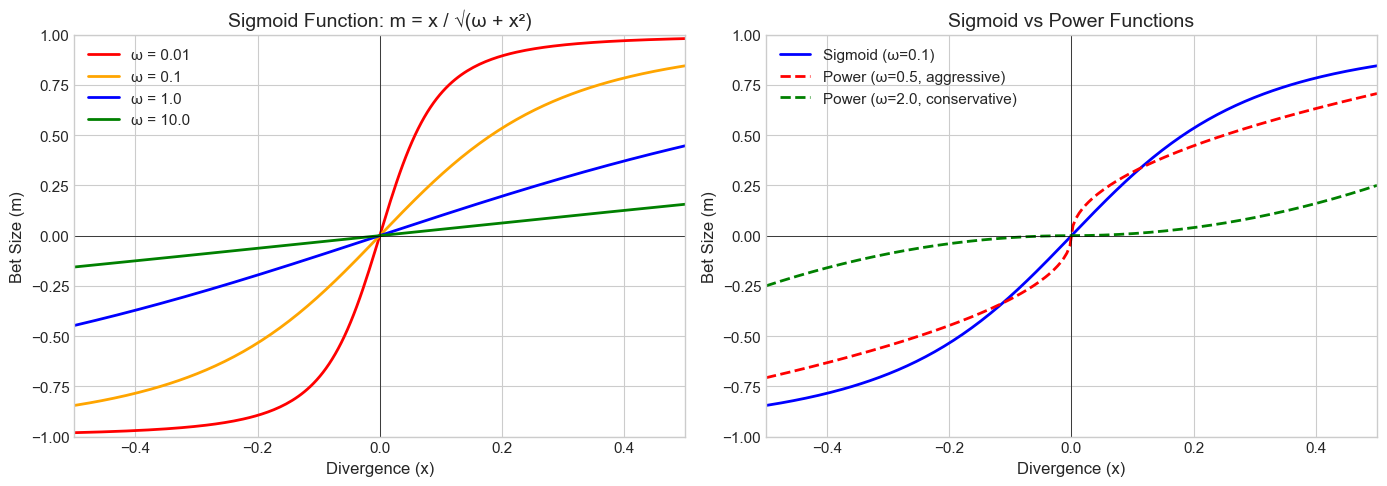

Left: Lower ω = faster response to divergence
Right: Power function can be more aggressive (ω<1) or conservative (ω>1)


In [14]:
# Visualize the sigmoid bet sizing function
divergences = np.linspace(-0.5, 0.5, 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Different omega values
ax1 = axes[0]
for omega, color in [(0.01, 'red'), (0.1, 'orange'), (1.0, 'blue'), (10.0, 'green')]:
    bet_sizes = [bet_size_sigmoid(d, omega) for d in divergences]
    ax1.plot(divergences, bet_sizes, color=color, linewidth=2, label=f'ω = {omega}')

ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.axvline(x=0, color='black', linewidth=0.5)
ax1.set_xlabel('Divergence (x)', fontsize=12)
ax1.set_ylabel('Bet Size (m)', fontsize=12)
ax1.set_title('Sigmoid Function: m = x / √(ω + x²)', fontsize=14)
ax1.legend()
ax1.set_xlim(-0.5, 0.5)
ax1.set_ylim(-1, 1)

# Right plot: Compare sigmoid vs power
ax2 = axes[1]
omega = 0.1
sigmoid_bets = [bet_size_sigmoid(d, omega) for d in divergences]
power_bets_05 = [bet_size_power(d, 0.5) for d in divergences]
power_bets_20 = [bet_size_power(d, 2.0) for d in divergences]

ax2.plot(divergences, sigmoid_bets, 'b-', linewidth=2, label='Sigmoid (ω=0.1)')
ax2.plot(divergences, power_bets_05, 'r--', linewidth=2, label='Power (ω=0.5, aggressive)')
ax2.plot(divergences, power_bets_20, 'g--', linewidth=2, label='Power (ω=2.0, conservative)')

ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linewidth=0.5)
ax2.set_xlabel('Divergence (x)', fontsize=12)
ax2.set_ylabel('Bet Size (m)', fontsize=12)
ax2.set_title('Sigmoid vs Power Functions', fontsize=14)
ax2.legend()
ax2.set_xlim(-0.5, 0.5)
ax2.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

print("Left: Lower ω = faster response to divergence")
print("Right: Power function can be more aggressive (ω<1) or conservative (ω>1)")

### Position Schedule

Given a forecast, we can create a **position schedule**: what position to hold at each price level.

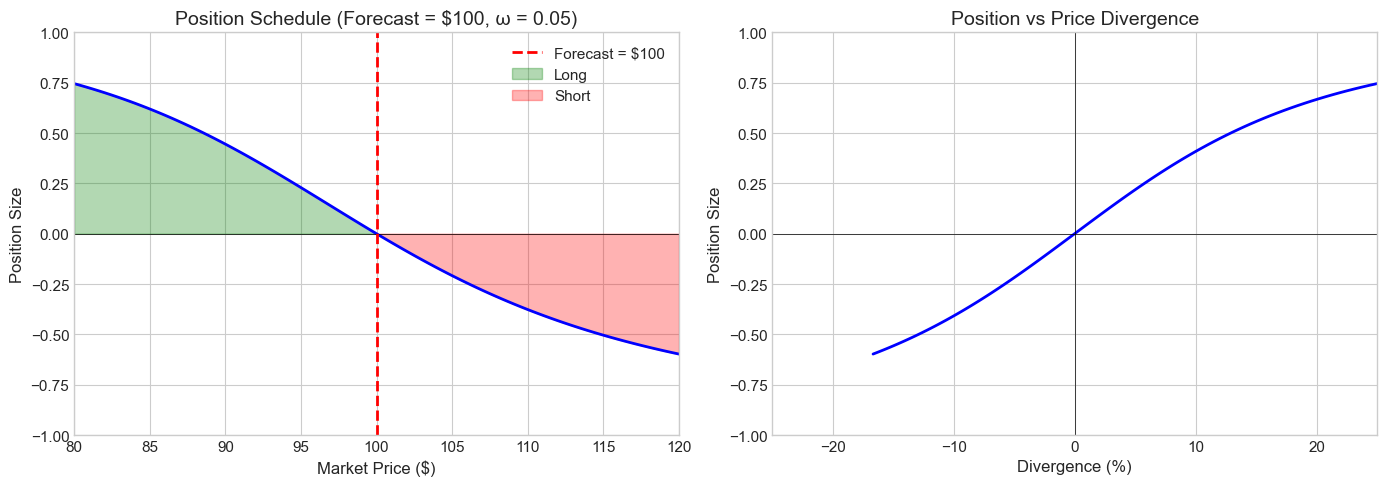


Interpretation:
  - Price = $90 (10% below forecast): Position = 0.41 (long)
  - Price = $100 (at forecast): Position = 0 (flat)
  - Price = $110 (10% above forecast): Position = -0.41 (short)


In [15]:
# Create position schedule for a stock
forecast = 100  # Fair value estimate
omega = 0.05    # Sensitivity parameter

schedule = get_position_schedule(
    forecast=forecast,
    price_range=(80, 120),
    omega=omega,
    num_points=100
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Position vs Price
ax1 = axes[0]
ax1.plot(schedule['price'], schedule['position'], 'b-', linewidth=2)
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.axvline(x=forecast, color='red', linestyle='--', linewidth=2, label=f'Forecast = ${forecast}')
ax1.fill_between(schedule['price'], 0, schedule['position'], 
                  where=(schedule['position'] > 0), alpha=0.3, color='green', label='Long')
ax1.fill_between(schedule['price'], 0, schedule['position'], 
                  where=(schedule['position'] < 0), alpha=0.3, color='red', label='Short')

ax1.set_xlabel('Market Price ($)', fontsize=12)
ax1.set_ylabel('Position Size', fontsize=12)
ax1.set_title(f'Position Schedule (Forecast = ${forecast}, ω = {omega})', fontsize=14)
ax1.legend()
ax1.set_xlim(80, 120)
ax1.set_ylim(-1, 1)

# Right: Position vs Divergence %
ax2 = axes[1]
ax2.plot(schedule['divergence_pct'] * 100, schedule['position'], 'b-', linewidth=2)
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.axvline(x=0, color='black', linewidth=0.5)

ax2.set_xlabel('Divergence (%)', fontsize=12)
ax2.set_ylabel('Position Size', fontsize=12)
ax2.set_title('Position vs Price Divergence', fontsize=14)
ax2.set_xlim(-25, 25)
ax2.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  - Price = $90 (10% below forecast): Position = {bet_size_sigmoid(0.10, omega):.2f} (long)")
print(f"  - Price = $100 (at forecast): Position = 0 (flat)")
print(f"  - Price = $110 (10% above forecast): Position = {bet_size_sigmoid(-0.10, omega):.2f} (short)")

### Limit Price Schedule

The **inverse** of the bet sizing function tells us: at what price should we update our position?

This is useful for placing limit orders at price levels where we want to adjust positions.

In [16]:
# Create limit price schedule
position_levels = np.array([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
forecast = 100
omega = 0.05

limit_schedule = get_limit_price_schedule(forecast, position_levels, omega)

print(f"Limit Price Schedule (Forecast = ${forecast}, ω = {omega}):")
print("=" * 50)
print(f"{'Position':>10} | {'Limit Price':>12} | {'Action':>15}")
print("-" * 50)

for _, row in limit_schedule.iterrows():
    pos = row['position']
    price = row['limit_price']
    if pos > 0:
        action = f"Buy at ${price:.2f}"
    elif pos < 0:
        action = f"Sell at ${price:.2f}"
    else:
        action = "Flat"
    print(f"{pos:>10.2f} | ${price:>11.2f} | {action:>15}")

Limit Price Schedule (Forecast = $100, ω = 0.05):
  Position |  Limit Price |          Action
--------------------------------------------------
     -0.75 | $     133.97 | Sell at $133.97
     -0.50 | $     114.82 | Sell at $114.82
     -0.25 | $     106.13 | Sell at $106.13
      0.00 | $     100.00 |            Flat
      0.25 | $      94.54 |   Buy at $94.54
      0.50 | $      88.57 |   Buy at $88.57
      0.75 | $      79.77 |   Buy at $79.77


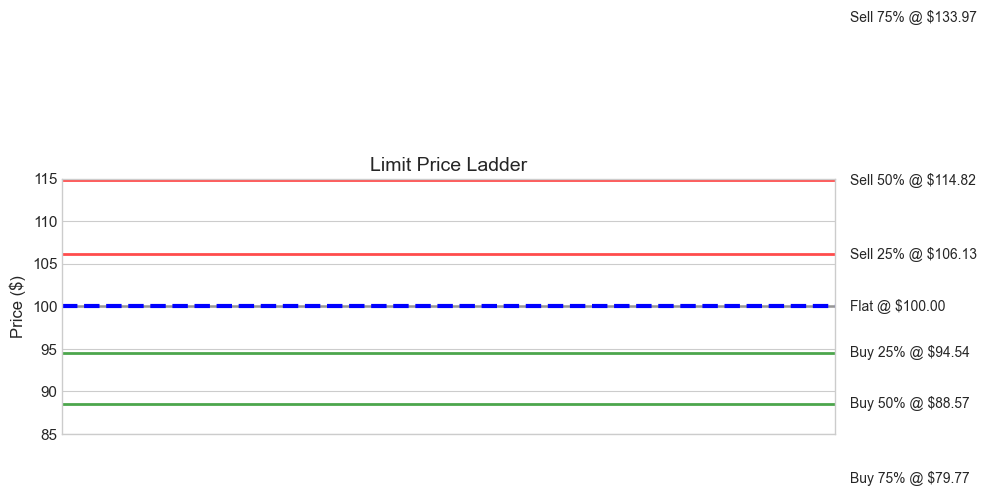


This ladder shows the prices at which to place limit orders for each position level.


In [17]:
# Visualize limit price ladder
fig, ax = plt.subplots(figsize=(10, 8))

# Plot limit prices as horizontal lines
for _, row in limit_schedule.iterrows():
    pos = row['position']
    price = row['limit_price']
    
    if pos > 0:
        color = 'green'
        label = f'Buy {abs(pos):.0%}'
    elif pos < 0:
        color = 'red'
        label = f'Sell {abs(pos):.0%}'
    else:
        color = 'gray'
        label = 'Flat'
    
    ax.axhline(y=price, color=color, linewidth=2, alpha=0.7)
    ax.text(1.02, price, f'{label} @ ${price:.2f}', 
            transform=ax.get_yaxis_transform(), fontsize=10, va='center')

# Mark forecast
ax.axhline(y=forecast, color='blue', linewidth=3, linestyle='--', label=f'Forecast = ${forecast}')

ax.set_xlim(0, 1)
ax.set_ylim(85, 115)
ax.set_ylabel('Price ($)', fontsize=12)
ax.set_title('Limit Price Ladder', fontsize=14)
ax.set_xticks([])

plt.tight_layout()
plt.show()

print("\nThis ladder shows the prices at which to place limit orders for each position level.")

### Dynamic Position Update

Combining dynamic sizing with discretization:

In [18]:
# Simulate dynamic position updates
print("Dynamic Position Update Simulation:")
print("=" * 70)

forecast = 100
omega = 0.05
step_size = 0.1
current_position = 0.0

# Simulate price path
prices = [100, 98, 96, 94, 96, 98, 102, 105, 103, 100]

print(f"Forecast = ${forecast}, ω = {omega}, Step = {step_size}")
print(f"\n{'Price':>8} | {'Target':>8} | {'Discrete':>10} | {'Trade?':>8} | {'Trade Size':>12}")
print("-" * 70)

position_history = []

for price in prices:
    result = dynamic_position_update(
        current_position=current_position,
        current_price=price,
        forecast=forecast,
        omega=omega,
        step_size=step_size
    )
    
    trade_str = "YES" if result['trade_required'] else "NO"
    trade_size = result['trade_size'] if result['trade_required'] else 0
    
    print(f"${price:>7} | {result['target_continuous']:>8.3f} | "
          f"{result['target_discrete']:>10.1f} | {trade_str:>8} | {trade_size:>+12.1f}")
    
    # Update position if trade required
    if result['trade_required']:
        current_position = result['target_discrete']
    
    position_history.append(current_position)

Dynamic Position Update Simulation:
Forecast = $100, ω = 0.05, Step = 0.1

   Price |   Target |   Discrete |   Trade? |   Trade Size
----------------------------------------------------------------------
$    100 |    0.000 |        0.0 |       NO |         +0.0
$     98 |    0.091 |        0.1 |      YES |         +0.1
$     96 |    0.183 |        0.2 |      YES |         +0.1
$     94 |    0.274 |        0.3 |      YES |         +0.1
$     96 |    0.183 |        0.2 |      YES |         -0.1
$     98 |    0.091 |        0.1 |      YES |         -0.1
$    102 |   -0.087 |       -0.1 |      YES |         -0.2
$    105 |   -0.208 |       -0.2 |      YES |         -0.1
$    103 |   -0.129 |       -0.1 |      YES |         +0.1
$    100 |    0.000 |        0.0 |      YES |         +0.1


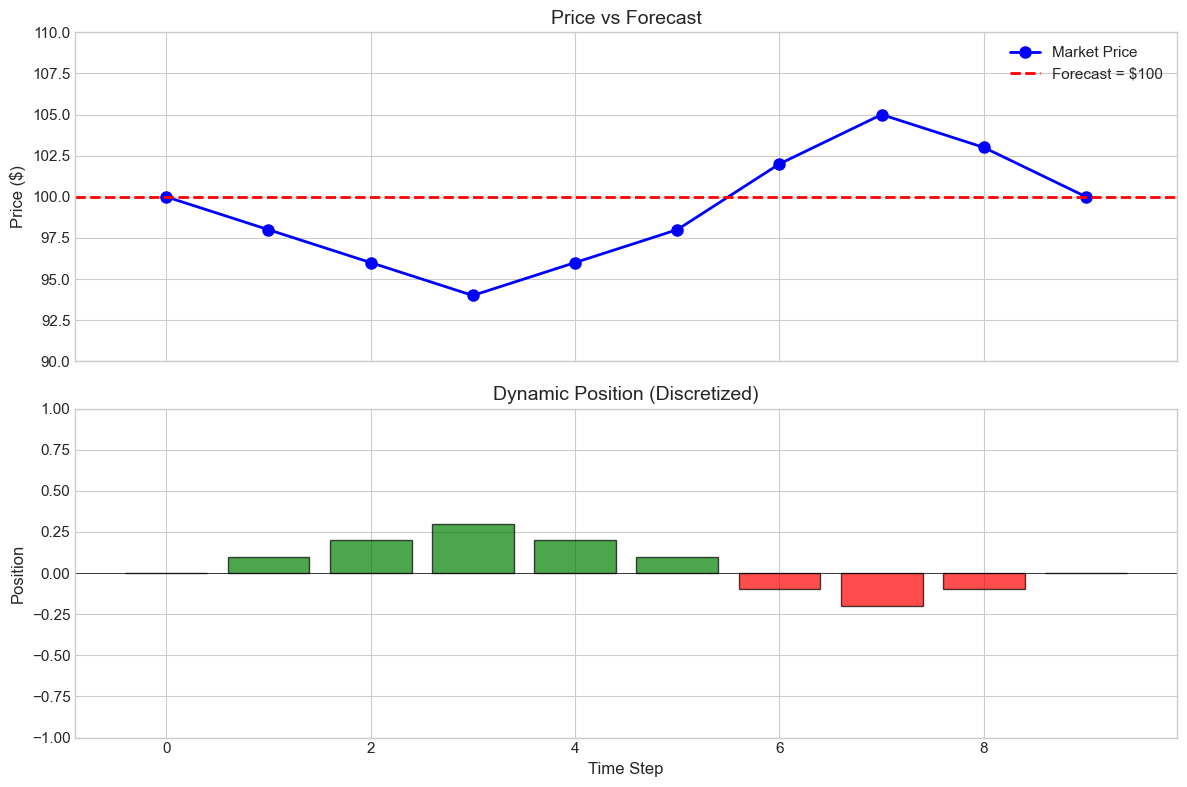


Position follows price divergence from forecast, with discrete steps.


In [19]:
# Visualize the simulation
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: Price and forecast
ax1 = axes[0]
ax1.plot(range(len(prices)), prices, 'b-o', linewidth=2, markersize=8, label='Market Price')
ax1.axhline(y=forecast, color='red', linestyle='--', linewidth=2, label=f'Forecast = ${forecast}')
ax1.set_ylabel('Price ($)', fontsize=12)
ax1.set_title('Price vs Forecast', fontsize=14)
ax1.legend()
ax1.set_ylim(90, 110)

# Bottom: Position
ax2 = axes[1]
colors = ['green' if p > 0 else ('red' if p < 0 else 'gray') for p in position_history]
ax2.bar(range(len(position_history)), position_history, color=colors, alpha=0.7, edgecolor='black')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_xlabel('Time Step', fontsize=12)
ax2.set_ylabel('Position', fontsize=12)
ax2.set_title('Dynamic Position (Discretized)', fontsize=14)
ax2.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

print("\nPosition follows price divergence from forecast, with discrete steps.")

---

## 5. Putting It All Together

Let's create a complete bet sizing pipeline that combines:
1. ML probability → bet size (z-score transformation)
2. Averaging of overlapping signals
3. Discretization
4. Trading decision

In [20]:
def complete_bet_sizing_pipeline(
    probabilities: pd.Series,
    predictions: pd.Series,
    events: pd.DataFrame,
    step_size: float = 0.1,
    num_classes: int = 2,
) -> dict:
    """
    Complete bet sizing pipeline.
    
    Parameters
    ----------
    probabilities : pd.Series
        ML model predicted probabilities
    predictions : pd.Series
        ML model predictions (side: -1 or 1)
    events : pd.DataFrame
        Events with 't1' column for end times
    step_size : float
        Discretization step size
    num_classes : int
        Number of classes
    
    Returns
    -------
    dict
        Dictionary with intermediate and final results
    """
    # Step 1: Convert probabilities to raw signals
    raw_signals = get_signal_from_probabilities(
        probabilities, predictions, num_classes=num_classes
    )
    
    # Step 2: Average overlapping signals
    avg_signals = compute_average_active_signals(raw_signals, events)
    
    # Step 3: Discretize
    discrete_signals = discretize_signal(avg_signals, step_size)
    
    # Step 4: Compute turnover
    turnover = discrete_signals.diff().abs().sum()
    
    return {
        'raw_signals': raw_signals,
        'avg_signals': avg_signals,
        'discrete_signals': discrete_signals,
        'total_turnover': turnover,
    }

# Create sample data
np.random.seed(42)
n_events = 20
dates = pd.date_range('2023-01-01', periods=n_events * 2, freq='D')

# Events with random holding periods (2-5 days)
start_dates = dates[:n_events]
holding_periods = np.random.randint(2, 6, n_events)
end_dates = [start_dates[i] + pd.Timedelta(days=int(holding_periods[i])) 
             for i in range(n_events)]

events = pd.DataFrame({'t1': end_dates}, index=start_dates)

# Random probabilities and predictions
probabilities = pd.Series(
    np.random.uniform(0.55, 0.9, n_events),
    index=start_dates
)
predictions = pd.Series(
    np.random.choice([-1, 1], n_events),
    index=start_dates
)

# Run pipeline
results = complete_bet_sizing_pipeline(
    probabilities=probabilities,
    predictions=predictions,
    events=events,
    step_size=0.1
)

print("Complete Bet Sizing Pipeline Results:")
print("=" * 50)
print(f"Number of events: {n_events}")
print(f"Total turnover: {results['total_turnover']:.2f}")

Complete Bet Sizing Pipeline Results:
Number of events: 20
Total turnover: 3.10


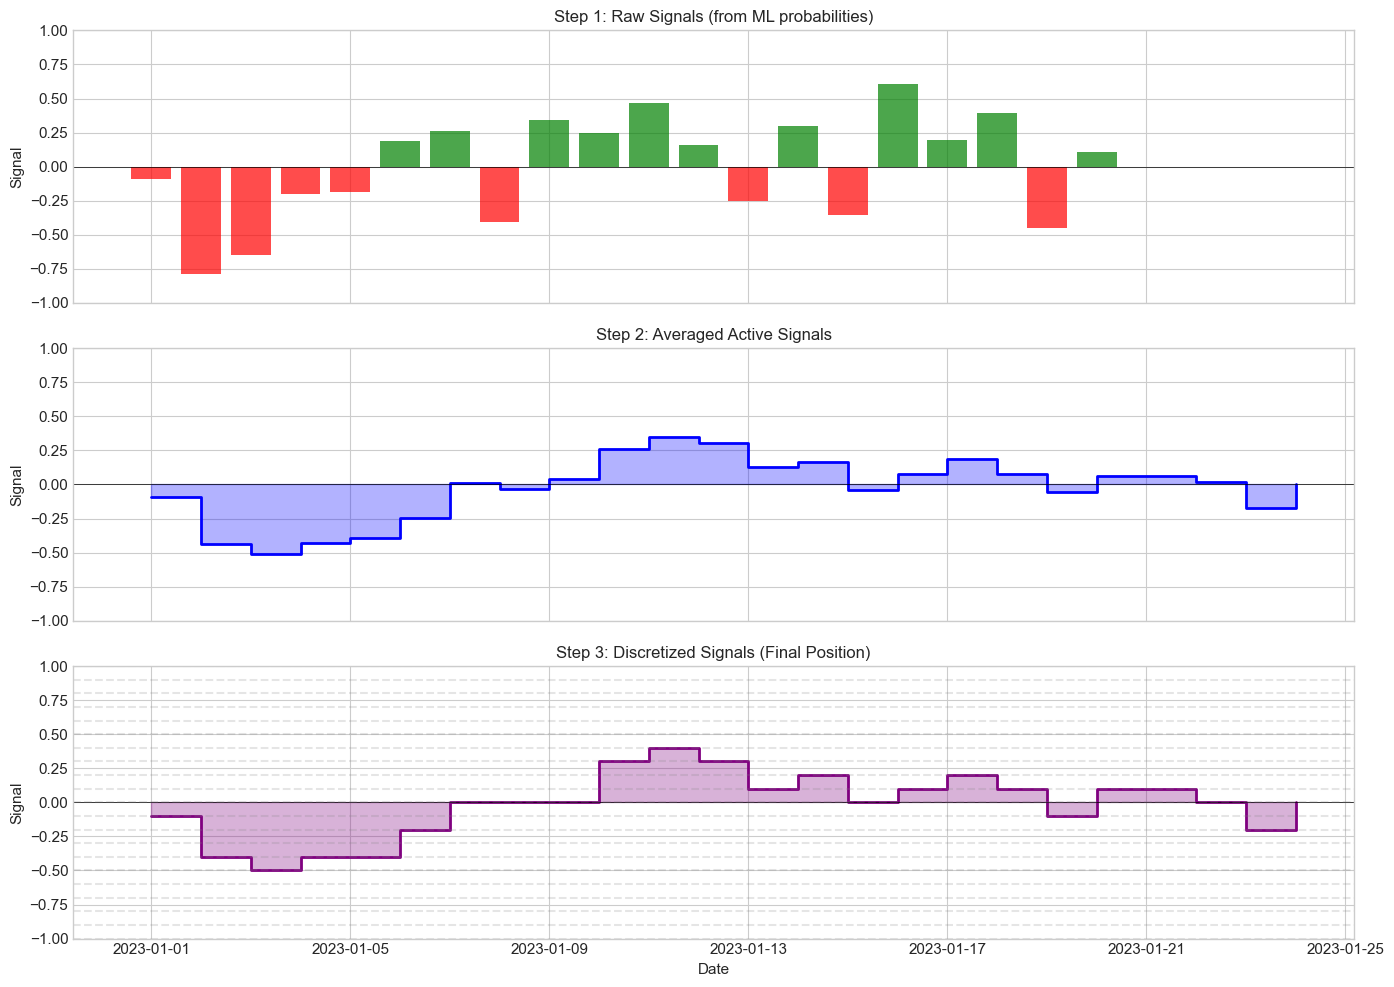

In [21]:
# Visualize the complete pipeline
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

# Plot 1: Raw signals (individual events)
ax1 = axes[0]
colors = ['green' if s > 0 else 'red' for s in results['raw_signals']]
ax1.bar(results['raw_signals'].index, results['raw_signals'].values, 
        color=colors, alpha=0.7, width=0.8)
ax1.axhline(y=0, color='black', linewidth=0.5)
ax1.set_ylabel('Signal', fontsize=11)
ax1.set_title('Step 1: Raw Signals (from ML probabilities)', fontsize=12)
ax1.set_ylim(-1, 1)

# Plot 2: Averaged signals
ax2 = axes[1]
ax2.step(results['avg_signals'].index, results['avg_signals'].values, 
         where='post', linewidth=2, color='blue')
ax2.fill_between(results['avg_signals'].index, 0, results['avg_signals'].values,
                  step='post', alpha=0.3, color='blue')
ax2.axhline(y=0, color='black', linewidth=0.5)
ax2.set_ylabel('Signal', fontsize=11)
ax2.set_title('Step 2: Averaged Active Signals', fontsize=12)
ax2.set_ylim(-1, 1)

# Plot 3: Discretized signals
ax3 = axes[2]
ax3.step(results['discrete_signals'].index, results['discrete_signals'].values,
         where='post', linewidth=2, color='purple')
ax3.fill_between(results['discrete_signals'].index, 0, results['discrete_signals'].values,
                  step='post', alpha=0.3, color='purple')
ax3.axhline(y=0, color='black', linewidth=0.5)

# Show discrete levels
for level in get_discrete_levels(0.1):
    ax3.axhline(y=level, color='gray', linestyle='--', alpha=0.2)

ax3.set_ylabel('Signal', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_title('Step 3: Discretized Signals (Final Position)', fontsize=12)
ax3.set_ylim(-1, 1)

plt.tight_layout()
plt.show()

### Comparing With and Without Averaging/Discretization

Turnover Comparison:
Raw (no averaging)                  | Turnover: 8.35
Averaged                            | Turnover: 2.84
Averaged + Discretized (0.1)        | Turnover: 3.10
Averaged + Discretized (0.2)        | Turnover: 2.80


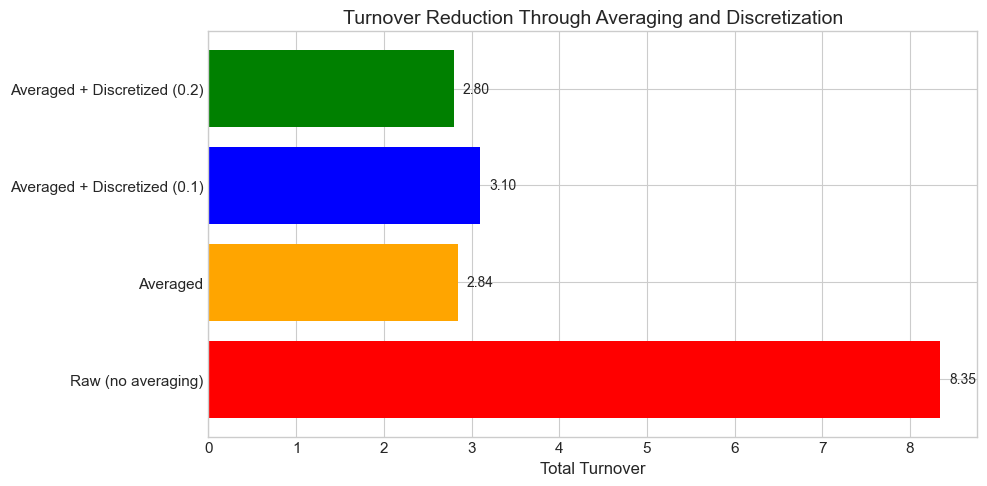


Turnover reduction: 66.5% (raw to averaged+discretized)


In [22]:
# Compare turnover with different pipeline configurations
configs = [
    ('Raw (no averaging)', results['raw_signals'].diff().abs().sum()),
    ('Averaged', results['avg_signals'].diff().abs().sum()),
    ('Averaged + Discretized (0.1)', results['discrete_signals'].diff().abs().sum()),
]

# Add discretization with larger step
discrete_02 = discretize_signal(results['avg_signals'], 0.2)
configs.append(('Averaged + Discretized (0.2)', discrete_02.diff().abs().sum()))

print("Turnover Comparison:")
print("=" * 50)
for name, turnover in configs:
    print(f"{name:35} | Turnover: {turnover:.2f}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 5))

names = [c[0] for c in configs]
turnovers = [c[1] for c in configs]

bars = ax.barh(names, turnovers, color=['red', 'orange', 'blue', 'green'])
ax.set_xlabel('Total Turnover', fontsize=12)
ax.set_title('Turnover Reduction Through Averaging and Discretization', fontsize=14)

# Add value labels
for bar, turnover in zip(bars, turnovers):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{turnover:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nTurnover reduction: {(1 - turnovers[-1]/turnovers[0])*100:.1f}% "
      f"(raw to averaged+discretized)")

---

## Summary

### Key Takeaways

1. **Probability → Bet Size**: Use the z-score transformation to convert ML probabilities to position sizes. This ensures that only statistically significant predictions lead to large positions.

2. **Averaging Active Bets**: When multiple signals overlap, average them. This reduces turnover and provides more stable positions.

3. **Discretization**: Round positions to discrete levels (e.g., 10%, 20%). This prevents overtrading from small signal changes.

4. **Dynamic Sizing**: For market makers with price forecasts, use the sigmoid function to size positions based on price-forecast divergence.

### The Complete Pipeline

```
ML Probabilities → Z-Score Transform → Raw Signals
                                           ↓
                                    Average Active
                                           ↓
                                     Discretize
                                           ↓
                                   Final Position
```

### Reference

López de Prado, M. (2018). *Advances in Financial Machine Learning*. Chapter 10: Bet Sizing.

In [23]:
print("Tutorial completed successfully!")
print("\nKey functions from afml.bet_sizing:")
print("  - compute_bet_size_from_probability()")
print("  - get_signal_from_probabilities()")
print("  - compute_average_active_signals()")
print("  - discretize_signal()")
print("  - bet_size_sigmoid()")
print("  - get_position_schedule()")
print("  - dynamic_position_update()")

Tutorial completed successfully!

Key functions from afml.bet_sizing:
  - compute_bet_size_from_probability()
  - get_signal_from_probabilities()
  - compute_average_active_signals()
  - discretize_signal()
  - bet_size_sigmoid()
  - get_position_schedule()
  - dynamic_position_update()
